In [252]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [253]:
def safelog(vals):
    return np.log(np.maximum(vals, 1e-10))
    
def normalize(vals):
    return vals / np.sum(vals, axis=1, keepdims=True)

def generate_lexicons(n_words, n_meanings):
        arrays =  np.array([list(map(int, list(np.binary_repr(i, width=n_words*n_meanings)))) 
                            for i in range(2**(n_words*n_meanings))])
        lexicons = arrays.reshape((2**(n_words*n_meanings), n_words, n_meanings))
        return lexicons[lexicons.sum(axis=1).min(axis=1) > 0]

In [317]:
class BaseRSA:
    def __init__(self, alpha, prior, C):
        self.alpha = alpha
        self.prior = prior
        self.C = C

    @staticmethod
    def safelog(vals):
        with np.errstate(divide='ignore'):
            return np.log(vals)

    @staticmethod
    def normalize(vals):
        return np.nan_to_num(vals / np.sum(vals, axis=-1, keepdims=True))
    
    def L_0(self, L):
        return self.normalize(L * self.prior)
    
    def S_p(self, L):
        return self.normalize(np.exp(self.alpha * (self.safelog(self.L_0(L).transpose(0, 2, 1)) - self.C)))
    
    def L_p(self, L):
        return self.normalize(self.S_p(L).transpose(0, 2, 1) * self.prior)

class Agent(BaseRSA):
    def __init__(self, alpha, prior, C, n_words, n_meanings):
        super().__init__(alpha, prior, C)
        self.Lexicons = generate_lexicons(n_words, n_meanings)
        self.prob_lexicon = np.ones(len(self.Lexicons)) / len(self.Lexicons)
        self.n_words = n_words
        self.n_meanings = n_meanings
    
    def speaker(self, m):
        # index of the lexicon with the highest probability given prob_lexicon
        lexicon_idx = np.random.choice(np.arange(len(self.Lexicons)), p=self.prob_lexicon)
        return self.S_p(self.Lexicons)[lexicon_idx][m].argmax()
    
    def listener(self, w):
        # index of the lexicon with the highest probability given prob_lexicon
        lexicon_idx = np.random.choice(np.arange(len(self.Lexicons)), p=self.prob_lexicon)
        return self.L_p(self.Lexicons)[lexicon_idx][w].argmax()
    
    def update(self, w, m):
        self.prob_lexicon = self.normalize(self.L_p(self.Lexicons)[:, w, m] * self.prob_lexicon) + 1e-10

In [318]:
prior = np.array([0.9, 0.1])
alpha = 5
C = np.array([0, 10])

In [319]:
def one_round(a, b, m):
    w = a.speaker(m)
    g = b.listener(w)
    if m == g:
        a.update(w, m)
        b.update(w, m)

In [320]:
a = Agent(alpha, prior, C, 2, 2)
b = Agent(alpha, prior, C, 2, 2)

posteriors = []

for _ in range(100):
    m = np.random.choice([0, 1])
    if _ % 2 == 0:
        one_round(a, b, m)
    else:
        one_round(b, a, m)

posteriors.append(a.prob_lexicon)
posteriors.append(b.prob_lexicon)


/var/folders/1c/pphtjl397rnbdcp94xmwzkqr0000gn/T/ipykernel_35761/675949791.py:14: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(vals / np.sum(vals, axis=-1, keepdims=True))


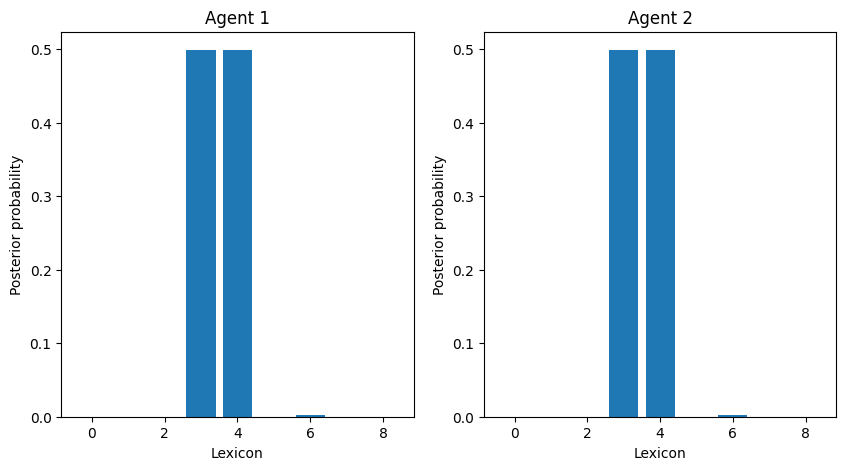

In [321]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for i, p in enumerate(posteriors):
    ax[i].bar(np.arange(len(p)), p)
    ax[i].set_title(f'Agent {i+1}')
    ax[i].set_xlabel('Lexicon')
    ax[i].set_ylabel('Posterior probability')

In [322]:
# get the lexicon with the highest probability
lexicon_idx = np.random.choice(np.arange(len(a.Lexicons)), p=a.prob_lexicon)
print(a.Lexicons[lexicon_idx])

[[1 0]
 [0 1]]


In [323]:
df = pd.DataFrame(a.Lexicons[lexicon_idx], columns=['m1', 'm2'], index=['w1', 'w2'])
# add row with prior
df.loc['prior'] = prior
# add column with costs (account for one new row)
df['costs'] = np.append(C, 0)

df

,m1,m2,costs
w1,1.0,0.0,0
w2,0.0,1.0,10
prior,0.9,0.1,0
